In [1]:
import itertools
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import logm, expm
from scipy.sparse.linalg import eigsh, svds
from pandas.plotting._matplotlib.style import get_standard_colors
colors = get_standard_colors(num_colors=13)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## functions to generate dynamic SBM based on given changepoints 

In [2]:
def create_SBM_parameters(n=50, p11=0.25, p12=0.05, minimum_average_node_per_block=5):
    num_blocks = 2 ** np.arange(np.log(n // minimum_average_node_per_block) / np.log(2))
    num_blocks = num_blocks.astype(int)
    size_prob_parameters = []
    for n_block in num_blocks:
        sizes = [n // n_block] * (n_block - 1)
        sizes.append(n - sum(sizes))
        p = (p11 - p12) * np.eye(n_block) + p12 * np.ones((n_block, n_block))
        size_prob_parameters.append([sizes, p])
        
    return size_prob_parameters

In [3]:
def generate_snapshot_on_consecutive_networks(G_old, G_new, alpha=0):
    if alpha == 0:
        return G_old
    if alpha == 1:
        return G_new
    return nx.from_edgelist([edge for u, edge in zip(np.random.rand(G_old.number_of_edges()), nx.to_edgelist(G_old)) if u < alpha] + \
                            [edge for u, edge in zip(np.random.rand(G_new.number_of_edges()), nx.to_edgelist(G_new)) if u > alpha])

In [4]:
def generate_dynamic_SBM(T=100, cps=None, n=50, p11=0.25, p12=0.05, alpha=0, directed=False):
    if cps is None:
        cps = [T//2]
    cps.sort()
    cp_counter = 0
    G_prev = None
    G_curr = None
    G_list = []
    size_prob_parameters = create_SBM_parameters(n, p11, p12)
    size_prob_index_prev = None
    size_prob_index_curr = np.random.choice(len(size_prob_parameters))
    for t in range(T):
        cp = False
        if cp_counter < len(cps) and t == cps[cp_counter]:
            cp = True
            if size_prob_index_prev is None:
                size_prob_index_prev = size_prob_index_curr
            while size_prob_index_curr == size_prob_index_prev:
                size_prob_index_curr = np.random.choice(len(size_prob_parameters))
            cp_counter += 1
        
        sizes, p = size_prob_parameters[size_prob_index_curr]
        G_curr = nx.stochastic_block_model(sizes, p, directed=directed)
        if G_prev is not None and cp == False:
            G_curr = generate_snapshot_on_consecutive_networks(G_prev, G_curr, alpha)
        G_list.append(G_curr)
        G_prev = G_curr
    
    return G_list, cps

## Fréchet Change Detection Binary Segmentation Algorithm

In [5]:
class ChangePointDetector:
    def __init__(self, G_list, c=2, epsilon=1e-2, B=100, m=100, alpha=0.05):
        """Detect multiple change points in a sequence of graph snapshots
        Parameters
        ----------
        G_list : `list`, len=(n_snapshots)
            List of networkx graphs.
        c : `int` or `float`, default=2
            Change points do not exist in the first and last few graphs in a sequence.
        epsilon: `float`, default=0.01
            The positive eigenvalue used to replace the zero eigenvalues of a Laplacian.
        B: `int`, default=100
            Bootstrap sample size
        m: `int`, default=100
            Length of each bootstrap sample
        alpha: `float`, default=0.05
            Significance level
        Returns
        -------
        """        
        self.logG_seq = logG_sequence(G_list, epsilon=epsilon)
        print(f"Finished computing the nearest SPDs of the input sequence of {len(G_list)} graphs")
        self.c = c
        self.epsilon = epsilon
        self.B = B
        self.m = m
        self.alpha = alpha
        self.cp_detected = []
        self.test_stats = []
    
    def frechet_stats_test(self, logG_seq):
        T = logG_seq.shape[0]
        if T <= 2*self.c + 2: return False, -1, -1
        print(f"Testing a sequence of {T} graphs")
        
        t1, t2 = since_until(T, self.c)
        
        test_stats_seq, since = test_statistics_online_two_pass(logG_seq, self.c)
        reference_stats = np.zeros(self.B, dtype=float)
        for b in range(self.B):
            reference_stats[b] = max(test_statistics_online_two_pass(logG_seq[np.random.choice(np.arange(T), size=self.m, replace=True)], self.c)[0]) #max(test_statistics_online_two_pass(logG_seq[np.random.choice(np.arange(T), size=T, replace=True)], self.c)[0])
        reference_stats.sort()
        q_one_minus_alpha = reference_stats[-int(self.alpha*self.B)]

        if max(test_stats_seq) > q_one_minus_alpha:
            return True, test_stats_seq.argmax() + since, (test_stats_seq, t1)
        else:
            return False, -1, -1
        
    def binary_segmentation(self, logG_seq=None, since=0):
        if logG_seq is None:
            logG_seq = self.logG_seq
        print(f"sequence: {since}, {since+logG_seq.shape[0]}")
        exist, loc, test_stats_seq = self.frechet_stats_test(logG_seq)
        if exist:
            self.cp_detected.append(loc+since)
            seq, t1 = test_stats_seq
            self.test_stats.append([seq, since+t1, since+t1+seq.shape[0]])
            self.binary_segmentation(logG_seq[:loc], since=since)
            self.binary_segmentation(logG_seq[loc:], since=loc+since)
            
    def restart(self):
        self.cp_detected = []
        self.test_stats = []

In [120]:
def since_until(T, c):
    if 0 < c < 1:
        since, until = int(np.ceil(c * T)), int(np.floor(T - c * T))
    elif c >= 1:
        since, until = int(c) + 1, T - int(c) - 1
    else:
        raise Exception("The interval parameter *c* is not valid.")
    
    return since, until

def dist(A, order=2):
#     return ((A ** 2).sum(axis=(1, 2)) ** (order//2)).sum()
    if order == 2:
        return np.einsum('ijk,ijk->...', A, A)
    else:
        return (np.einsum('ijk,ijk->i', A, A)**(order//2)).sum()

def logG_sequence(G_list, epsilon=1e-2):
    # construct the sequence of matrix logarithms of the nearest SPDs
    directed = G_list[0].is_directed()
    max_nodes = max([G.number_of_nodes() for G in G_list])
    T = len(G_list)
    logG_seq = np.zeros((T, max_nodes, max_nodes))
    for t, G_t in enumerate(G_list):
        if G_t.number_of_nodes() < max_nodes:
            G_t.add_nodes_from([-i for i in range(G_t.number_of_nodes(), max_nodes)])
        if directed:
            L_t = nx.directed_laplacian_matrix(G_t).A
            L_t = (L_t + L_t.T) / 2
        else:
            L_t = nx.laplacian_matrix(G_t).asfptype().toarray()
            
        vecs, vals, _ = svds(L_t, k=max_nodes-1, which="LM")
        vals[vals <= 0] = epsilon
        logG_t = vecs @ np.diag(np.log(vals)) @ vecs.T
        logG_seq[t] = logG_t
        
    return logG_seq

def test_statistics_online_two_pass(X_seq, c):
    if isinstance(X_seq, list):
        T = len(X_seq)
    else:
        T = X_seq.shape[0]

    since, until = since_until(T, c)
    
    test_stats_seq = np.zeros(until - since, dtype=np.float64)
    sample_mu = X_seq.mean(axis=0)
    sample_V = (
        dist(X_seq - sample_mu) / T
    )
    sigma2 = dist(X_seq - sample_mu, order=4) / T - sample_V**2
    mu1_seq = np.zeros((until - since, *X_seq.shape[1:]), dtype=np.float64)
    mu2_seq = np.zeros((until - since, *X_seq.shape[1:]), dtype=np.float64)
    V1_seq = np.zeros(until - since, dtype=np.float64)
    V2_seq = np.zeros(until - since, dtype=np.float64)

    for idx, tau in enumerate(range(since, until)):
        if idx == 0:
            mu1 = X_seq[:tau].mean(axis=0)
            V1 = dist(X_seq[:tau] - mu1) / tau
        else:
            mu1_new = mu1 + 1 / tau * (X_seq[tau - 1] - mu1)
            V1 = V1 + (
                -V1 + np.einsum("ij,ij", X_seq[tau - 1] - mu1, X_seq[tau - 1] - mu1_new)
            ) / (tau)
            mu1 = mu1_new
        mu1_seq[idx] = mu1
        V1_seq[idx] = V1

    for idx, tau in enumerate(reversed(range(since, until))):
        if idx == 0:
            mu2 = X_seq[tau:].mean(axis=0)
            V2 = dist(X_seq[tau:] - mu2) / (T - tau)
        else:
            mu2_new = mu2 + 1 / (T - tau) * (X_seq[tau] - mu2)
            V2 = V2 + (
                -V2 + np.einsum("ij,ij", X_seq[tau] - mu2, X_seq[tau] - mu2_new)
            ) / (T - tau)
            mu2 = mu2_new
        mu2_seq[idx] = mu2
        V2_seq[idx] = V2

    mu2_seq = mu2_seq[::-1]
    V2_seq = V2_seq[::-1]
    mu_diff_seq = np.einsum("ijk,ijk->i", mu2_seq - mu1_seq, mu2_seq - mu1_seq)
    Vc1_seq = V1_seq + mu_diff_seq
    Vc2_seq = V2_seq + mu_diff_seq
    test_stats_seq = (
        np.arange(since, until)
        * (T - 1 - np.arange(since, until))
        / T**2
        / sigma2
        * ((V1_seq - V2_seq) ** 2 + (Vc1_seq - V1_seq + Vc2_seq - V2_seq) ** 2)
    )

    return T * test_stats_seq, since

## baseline method: [LAD](https://github.com/shenyangHuang/LAD)

In [155]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

def compute_z_score_single(curr_vec, typical_vec):
    if len(curr_vec.shape) != 2:
        curr_vec = curr_vec.reshape(1, -1)
    if len(typical_vec.shape) != 2:
        typical_vec = typical_vec.reshape(1, -1)    
    return 1 - np.abs(cosine_similarity(curr_vec, typical_vec))

def compute_typical_vector_from_window(eigenvalue_list_window, principal=True):
    if principal == False:
        return np.mean(eigenvalue_list_window, axis=0)
    eigenvalue_list_window = eigenvalue_list_window.T # transpose so that time is along the 1-axis
    u, _, _ = np.linalg.svd(eigenvalue_list_window, full_matrices=False)
    return u[:, 0]

def compute_z_score_sequence_two_windows(eigenvalue_list, principal=True, window1=None, window2=None, initial_window=None, difference=True):
    T = eigenvalue_list.shape[0]
    if initial_window is None:
        initial_window = T // 20
    if window1 is None:
        window1 = T // 100
    if window2 is None:
        window2 = T // 50
    if initial_window < max(window1, window2):
        initial_window = max(window1, window2)
    
    z1_list = np.zeros(T)
    z2_list = np.zeros(T)
    for t in range(initial_window, T):
        typical_vec = compute_typical_vector_from_window(eigenvalue_list[t-window1:t], principal=principal)
        z1 = compute_z_score_single(eigenvalue_list[t], typical_vec)
        typical_vec = compute_typical_vector_from_window(eigenvalue_list[t-window2:t], principal=principal)
        z2 = compute_z_score_single(eigenvalue_list[t], typical_vec)
        z1_list[t] = z1
        z2_list[t] = z2
    
    if difference:
        z1_list = np.diff(z1_list, prepend=0)
        z2_list = np.diff(z2_list, prepend=0)
    z_list = np.maximum(z1_list, z2_list)
    return z_list

def LAD(G_list, cps_true=None, num_eigens=None, principal=True, window1=None, window2=None, initial_window=None, difference=True):
    directed = G_list[0].is_directed()
    max_nodes = max([G.number_of_nodes() for G in G_list])
    
    if num_eigens is None:
        num_eigens = max_nodes // 2 # G_list[0].number_of_nodes() // 10
    if cps_true is None:
        num_detections = len(G_list) // 25
    else:
        num_detections = len(cps_true)
    eigenvalue_list = np.zeros((len(G_list), num_eigens), dtype=float)
    for t, G_t in enumerate(G_list):
        if G_t.number_of_nodes() < max_nodes:
            G_t.add_nodes_from([-i for i in range(G_t.number_of_nodes(), max_nodes)])
        if directed:
            L_t = nx.directed_laplacian_matrix(G_t)
        else:
            L_t = nx.laplacian_matrix(G_t).asfptype()
        vecs, vals, _ = svds(L_t, k=num_eigens, which="LM")
        eigenvalue_list[t] = vals
    eigenvalue_list = eigenvalue_list.real
    eigenvalue_list = normalize(eigenvalue_list, norm='l2')
    
    z_list = compute_z_score_sequence_two_windows(eigenvalue_list, principal=principal, window1=window1, window2=window2, initial_window=initial_window, difference=difference)
    cps_LAD = z_list.argsort()[::-1][:num_detections]
    if cps_true is not None:
        accuracy = len(set(cps_true).intersection(set(cps_LAD))) / len(cps_true)
    else:
        accuracy = None
    return accuracy, cps_LAD, z_list

## load Enron graphs and other real-world datasets

In [8]:
def load_object(filename):
    with open(filename, 'rb') as fp:
        output = pickle.load(fp)
    return output

def save_object(obj, filename):
    with open(filename, 'wb') as fp:
        pickle.dump(obj, fp)

In [9]:
enron = load_object('datasets/enron_weekly.pkl')

In [10]:
UCI = load_object('datasets/UCI.pkl')

In [62]:
conf = load_object('datasets/conf.pkl')

In [152]:
stackoverflow = load_object('datasets/stackoverflow.pkl')

### Stackoverflow Answers

In [182]:
stackoverflow_cp = ChangePointDetector(stackoverflow, c=12, alpha=0.3)
stackoverflow_cp.binary_segmentation()
_, cps_LAD_stackoverflow, LAD_list_stackoverflow = LAD(stackoverflow, cps_true=stackoverflow_cp.cp_detected, window1=14, window2=7)
print(
    f"Detected (Fréchet): {stackoverflow_cp.cp_detected}; Detected (LAD): {cps_LAD_stackoverflow}"
) 


Finished computing the nearest SPDs of the input sequence of 240 graphs
sequence: 0, 240
Testing a sequence of 240 graphs
sequence: 0, 208
Testing a sequence of 208 graphs
sequence: 0, 32
Testing a sequence of 32 graphs
sequence: 0, 14
sequence: 14, 32
sequence: 32, 208
Testing a sequence of 176 graphs
sequence: 32, 51
sequence: 51, 208
Testing a sequence of 157 graphs
sequence: 51, 78
Testing a sequence of 27 graphs
sequence: 51, 64
sequence: 64, 78
sequence: 78, 208
Testing a sequence of 130 graphs
sequence: 78, 101
sequence: 101, 208
Testing a sequence of 107 graphs
sequence: 101, 127
sequence: 127, 208
Testing a sequence of 81 graphs
sequence: 127, 148
sequence: 148, 208
Testing a sequence of 60 graphs
sequence: 148, 176
Testing a sequence of 28 graphs
sequence: 148, 161
sequence: 161, 176
sequence: 176, 208
Testing a sequence of 32 graphs
sequence: 176, 194
sequence: 194, 208
sequence: 208, 240
Testing a sequence of 32 graphs
sequence: 208, 224
sequence: 224, 240
Detected (Fréchet

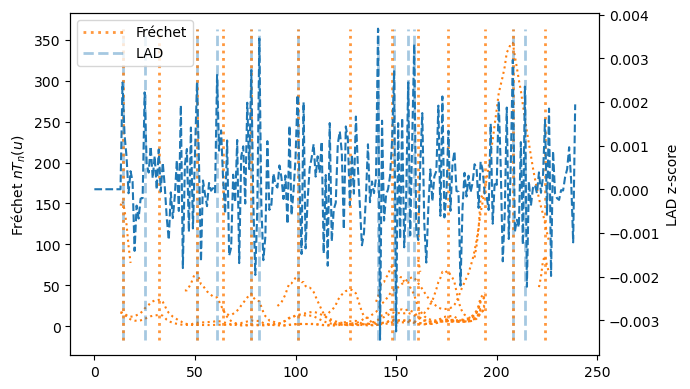

In [183]:
fig, ax = plt.subplots(figsize=(7, 4))
ax1 = ax.twinx()
ax1.plot(LAD_list_stackoverflow, color=colors[0], ls="--", label='LAD') #marker='o', markevery=5

# ax.set_ylim([0, 200])
for i, test_stats in enumerate(stackoverflow_cp.test_stats):
    seq, since, until = test_stats
    ax.plot(np.arange(since, until), seq, ls=":", color=colors[1], label='Fréchet') #marker='*', markevery=5,

ymin, ymax = ax.get_ylim() 
for changepoint in cps_LAD_stackoverflow:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[0], ls="--", lw=2, alpha=0.4)
for changepoint in stackoverflow_cp.cp_detected:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[1], ls=":", lw=2, alpha=0.8)

# ax.legend(lines, labels, loc="upper left")
dummy_lines = [ax.plot([], color=c, ls=l, lw=w, alpha=a)[0] for c, l, w, a in zip([colors[1], colors[0]],
                                                                     [':', '--'], [2, 2], [0.8, 0.4])]
ax.legend(dummy_lines, ['Fréchet', 'LAD'], loc="upper left", handlelength=3)

ax.set_ylabel('Fréchet ' + r"$nT_n(u)$")
ax1.set_ylabel('LAD z-score')
# ax.set_title("SFHH Conference Interaction Network")
plt.tight_layout()
plt.savefig('figures/stackoverflow.png', dpi=100)

### SFHH Conference

In [163]:
conf_cp = ChangePointDetector(conf, c=2, alpha=0.2)
conf_cp.binary_segmentation()
_, cps_LAD_conf, LAD_list_conf = LAD(conf, cps_true=conf_cp.cp_detected, window1=14, window2=7)
print(
    f"Detected (Fréchet): {conf_cp.cp_detected}; Detected (LAD): {cps_LAD_conf}"
) 


Finished computing the nearest SPDs of the input sequence of 157 graphs
sequence: 0, 157
Testing a sequence of 157 graphs
sequence: 0, 3
sequence: 3, 157
Testing a sequence of 154 graphs
sequence: 3, 76
Testing a sequence of 73 graphs
sequence: 3, 15
Testing a sequence of 12 graphs
sequence: 3, 6
sequence: 6, 15
Testing a sequence of 9 graphs
sequence: 6, 9
sequence: 9, 15
sequence: 15, 76
Testing a sequence of 61 graphs
sequence: 15, 25
Testing a sequence of 10 graphs
sequence: 15, 18
sequence: 18, 25
Testing a sequence of 7 graphs
sequence: 25, 76
Testing a sequence of 51 graphs
sequence: 76, 157
Testing a sequence of 81 graphs
sequence: 76, 114
Testing a sequence of 38 graphs
sequence: 114, 157
Testing a sequence of 43 graphs
sequence: 114, 124
Testing a sequence of 10 graphs
sequence: 124, 157
Testing a sequence of 33 graphs
sequence: 124, 150
Testing a sequence of 26 graphs
sequence: 150, 157
Testing a sequence of 7 graphs
sequence: 150, 153
sequence: 153, 157
Detected (Fréchet): 

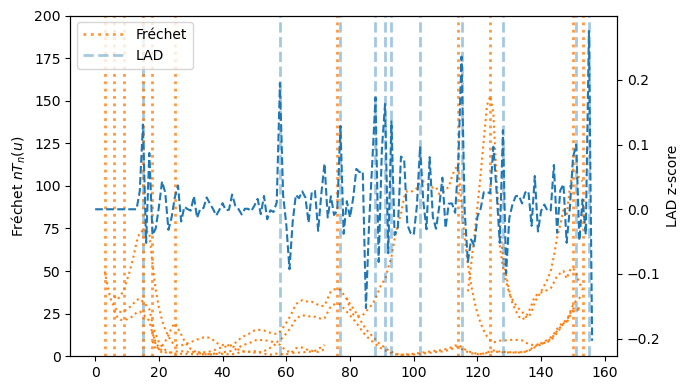

In [174]:
fig, ax = plt.subplots(figsize=(7, 4))
ax1 = ax.twinx()
ax1.plot(LAD_list_conf, color=colors[0], ls="--", label='LAD') #marker='o', markevery=5

ax.set_ylim([0, 200])
for i, test_stats in enumerate(conf_cp.test_stats):
    seq, since, until = test_stats
    ax.plot(np.arange(since, until), seq, ls=":", color=colors[1], label='Fréchet') #marker='*', markevery=5,

ymin, ymax = ax.get_ylim() 
for changepoint in cps_LAD_conf:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[0], ls="--", lw=2, alpha=0.4)
for changepoint in conf_cp.cp_detected:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[1], ls=":", lw=2, alpha=0.8)

# ax.legend(lines, labels, loc="upper left")
dummy_lines = [ax.plot([], color=c, ls=l, lw=w, alpha=a)[0] for c, l, w, a in zip([colors[1], colors[0]],
                                                                     [':', '--'], [2, 2], [0.8, 0.4])]
ax.legend(dummy_lines, ['Fréchet', 'LAD'], loc="upper left", handlelength=3)

ax.set_ylabel('Fréchet ' + r"$nT_n(u)$")
ax1.set_ylabel('LAD z-score')
# ax.set_title("SFHH Conference Interaction Network")
plt.tight_layout()
plt.savefig('figures/SFHH.png', dpi=100)

### Synthetic network

In [11]:
T = 200
num_cps = 5
cps = None
while cps is None or (np.diff(np.sort(cps)) < 10).any():
    cps = np.random.choice(np.arange(25, T - 5), num_cps, replace=False)

n = 100
directed = False
G_list, cps = generate_dynamic_SBM(T, cps, n, directed=directed)
_, cps_LAD_Synthetic, LAD_list_Synthetic = LAD(G_list, cps)
Synthetic_cp = ChangePointDetector(G_list, c=4, alpha=0.05)
Synthetic_cp.binary_segmentation()
print(
    f"Detected (Fréchet): {Synthetic_cp.cp_detected}; Detected (LAD): {cps_LAD_Synthetic}; True: {cps}"
)

Finished computing the nearest SPDs of the input sequence of 200 graphs
sequence: 0, 200
Testing a sequence of 200 graphs
sequence: 0, 56
Testing a sequence of 56 graphs
sequence: 56, 200
Testing a sequence of 144 graphs
sequence: 56, 91
Testing a sequence of 35 graphs
sequence: 91, 200
Testing a sequence of 109 graphs
sequence: 91, 127
Testing a sequence of 36 graphs
sequence: 127, 200
Testing a sequence of 73 graphs
sequence: 127, 186
Testing a sequence of 59 graphs
sequence: 127, 140
Testing a sequence of 13 graphs
sequence: 140, 186
Testing a sequence of 46 graphs
sequence: 186, 200
Testing a sequence of 14 graphs
Detected (Fréchet): [56, 91, 127, 186, 140]; Detected (LAD): [ 56 140 186  91 127]; True: [ 56  91 127 140 186]


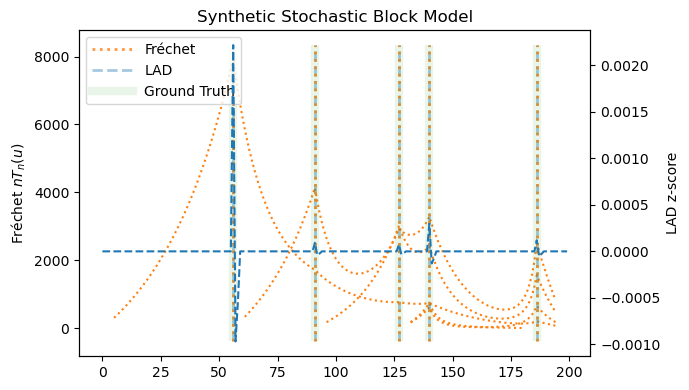

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))
ax1 = ax.twinx()
ax1.plot(LAD_list_Synthetic, color=colors[0], ls="--", label='LAD') #marker='o', markevery=5

for i, test_stats in enumerate(Synthetic_cp.test_stats):
    seq, since, until = test_stats
    ax.plot(np.arange(since, until), seq, ls=":", color=colors[1], label='Fréchet') #marker='*', markevery=5,

# lines, labels = [], []
# for axis in [ax, ax1]:
#     line, label = axis.get_legend_handles_labels()
#     lines.append(line[0] if isinstance(line, list) else line)
#     labels.append(label[0] if isinstance(label, list) else label)

ymin, ymax = ax.get_ylim() 
for changepoint in cps_LAD_Synthetic:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[0], ls="--", lw=2, alpha=0.4)
for changepoint in Synthetic_cp.cp_detected:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[1], ls=":", lw=2, alpha=0.8)
for changepoint in cps:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[-1], ls='-', lw=6, alpha=0.1)

# ax.legend(lines, labels, loc="upper left")
dummy_lines = [ax.plot([], color=c, ls=l, lw=w, alpha=a)[0] for c, l, w, a in zip([colors[1], colors[0], colors[-1]],
                                                                     [':', '--', '-'], [2, 2, 6], [0.8, 0.4, 0.1])]
ax.legend(dummy_lines, ['Fréchet', 'LAD', 'Ground Truth'], loc="upper left", handlelength=3)

ax.set_ylabel('Fréchet ' + r"$nT_n(u)$")
ax1.set_ylabel('LAD z-score')
ax.set_title("Synthetic Stochastic Block Model")
plt.tight_layout()
plt.savefig('figures/synthetic network.png', dpi=600)

### UCI message network

In [13]:
UCI_cp = ChangePointDetector(UCI, c=2, alpha=0.2)
UCI_cp.binary_segmentation()
_, cps_LAD_UCI, LAD_list_UCI = LAD(UCI, cps_true=UCI_cp.cp_detected, window1=14, window2=7)
print(
    f"Detected (Fréchet): {UCI_cp.cp_detected}; Detected (LAD): {cps_LAD_UCI}"
)

Finished computing the nearest SPDs of the input sequence of 196 graphs
sequence: 0, 196
Testing a sequence of 196 graphs
sequence: 0, 62
Testing a sequence of 62 graphs
sequence: 0, 5
sequence: 5, 62
Testing a sequence of 57 graphs
sequence: 5, 8
sequence: 8, 62
Testing a sequence of 54 graphs
sequence: 8, 11
sequence: 11, 62
Testing a sequence of 51 graphs
sequence: 11, 14
sequence: 14, 62
Testing a sequence of 48 graphs
sequence: 14, 17
sequence: 17, 62
Testing a sequence of 45 graphs
sequence: 62, 196
Testing a sequence of 134 graphs
sequence: 62, 177
Testing a sequence of 115 graphs
sequence: 62, 74
Testing a sequence of 12 graphs
sequence: 74, 177
Testing a sequence of 103 graphs
sequence: 74, 93
Testing a sequence of 19 graphs
sequence: 93, 177
Testing a sequence of 84 graphs
sequence: 177, 196
Testing a sequence of 19 graphs
Detected (Fréchet): [62, 5, 8, 11, 14, 17, 177, 74, 93]; Detected (LAD): [62 74 15 14 45 19 51 94 22]


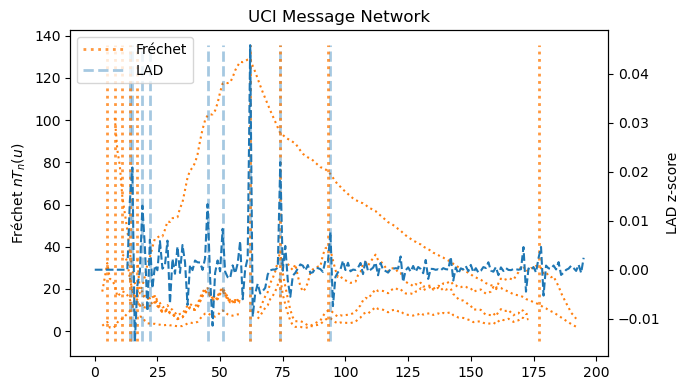

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))
ax1 = ax.twinx()
ax1.plot(LAD_list_UCI, color=colors[0], ls="--", label='LAD') #marker='o', markevery=5

for i, test_stats in enumerate(UCI_cp.test_stats):
    seq, since, until = test_stats
    ax.plot(np.arange(since, until), seq, ls=":", color=colors[1], label='Fréchet') #marker='*', markevery=5,

# lines, labels = [], []
# for axis in [ax, ax1]:
#     line, label = axis.get_legend_handles_labels()
#     lines.append(line[0] if isinstance(line, list) else line)
#     labels.append(label[0] if isinstance(label, list) else label)

ymin, ymax = ax.get_ylim() 
for changepoint in cps_LAD_UCI:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[0], ls="--", lw=2, alpha=0.4)
for changepoint in UCI_cp.cp_detected:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[1], ls=":", lw=2, alpha=0.8)

# ax.legend(lines, labels, loc="upper left")
dummy_lines = [ax.plot([], color=c, ls=l, lw=w, alpha=a)[0] for c, l, w, a in zip([colors[1], colors[0]],
                                                                     [':', '--'], [2, 2], [0.8, 0.4])]
ax.legend(dummy_lines, ['Fréchet', 'LAD'], loc="upper left", handlelength=3)

ax.set_ylabel('Fréchet ' + r"$nT_n(u)$")
ax1.set_ylabel('LAD z-score')
ax.set_title("UCI Message Network")
plt.tight_layout()
plt.savefig('figures/UCI.png', dpi=600)

### Enron email network

In [15]:
Enron_cp = ChangePointDetector(enron, c=2, alpha=0.6)
Enron_cp.binary_segmentation()
_, cps_LAD_Enron, LAD_list_Enron = LAD(enron, cps_true=Enron_cp.cp_detected)
print(
    f"Detected (Fréchet): {Enron_cp.cp_detected}; Detected (LAD): {cps_LAD_Enron}"
)


Finished computing the nearest SPDs of the input sequence of 184 graphs
sequence: 0, 184
Testing a sequence of 184 graphs
sequence: 0, 77
Testing a sequence of 77 graphs
sequence: 0, 52
Testing a sequence of 52 graphs
sequence: 0, 21
Testing a sequence of 21 graphs
sequence: 0, 10
Testing a sequence of 10 graphs
sequence: 10, 21
Testing a sequence of 11 graphs
sequence: 21, 52
Testing a sequence of 31 graphs
sequence: 21, 25
sequence: 25, 52
Testing a sequence of 27 graphs
sequence: 25, 33
Testing a sequence of 8 graphs
sequence: 33, 52
Testing a sequence of 19 graphs
sequence: 33, 36
sequence: 36, 52
Testing a sequence of 16 graphs
sequence: 36, 39
sequence: 39, 52
Testing a sequence of 13 graphs
sequence: 52, 77
Testing a sequence of 25 graphs
sequence: 77, 184
Testing a sequence of 107 graphs
sequence: 77, 173
Testing a sequence of 96 graphs
sequence: 77, 167
Testing a sequence of 90 graphs
sequence: 77, 90
Testing a sequence of 13 graphs
sequence: 77, 80
sequence: 80, 90
Testing a 

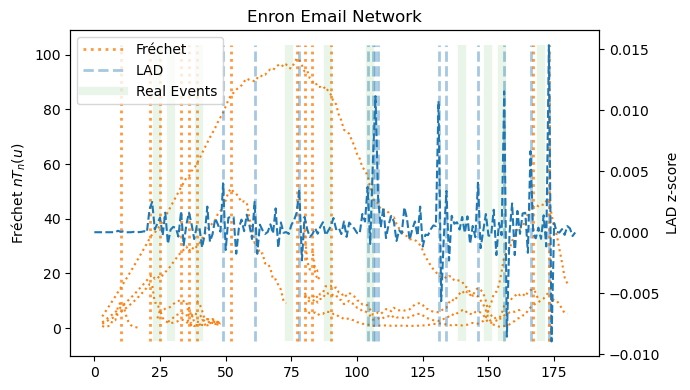

In [16]:
cps_true_Enron = [24, 29, 40, 74, 89, 105, 140, 150, 155, 170]
fig, ax = plt.subplots(figsize=(7, 4))
ax1 = ax.twinx()
ax1.plot(LAD_list_Enron, color=colors[0], ls="--", label='LAD') #marker='o', markevery=5

for i, test_stats in enumerate(Enron_cp.test_stats):
    seq, since, until = test_stats
    ax.plot(np.arange(since, until), seq, ls=":", color=colors[1], label='Fréchet') #marker='*', markevery=5,

ymin, ymax = ax.get_ylim() 
for changepoint in cps_LAD_Enron:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[0], ls="--", lw=2, alpha=0.4)
for changepoint in Enron_cp.cp_detected:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[1], ls=":", lw=2, alpha=0.8)
for changepoint in cps_true_Enron:
    ax.vlines(x=changepoint, ymin=ymin, ymax=ymax, color=colors[-1], ls='-', lw=6, alpha=0.1)

# ax.legend(lines, labels, loc="upper left")
dummy_lines = [ax.plot([], color=c, ls=l, lw=w, alpha=a)[0] for c, l, w, a in zip([colors[1], colors[0], colors[-1]],
                                                                     [':', '--', '-'], [2, 2, 6], [0.8, 0.4, 0.1])]
ax.legend(dummy_lines, ['Fréchet', 'LAD', 'Real Events'], loc="upper left", handlelength=3)

ax.set_ylabel('Fréchet ' + r"$nT_n(u)$")
ax1.set_ylabel('LAD z-score')
ax.set_title("Enron Email Network")
plt.tight_layout()
plt.savefig('figures/enron.png', dpi=600)